### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

### Suppress warnings and set plot style

In [2]:
warnings.simplefilter(action ='ignore')
plt.style.use('seaborn')

### Read from the CSV File

In [3]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Look at the statistics of the dataset

In [4]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


### Look at number of Nulls and data types

In [5]:
data_types = pd.DataFrame(df.dtypes, columns=['Data Types'])
count_of_nulls = pd.DataFrame(df.isnull().sum(), columns=['Count of Nulls'])
data_dictionary = pd.concat([data_types, count_of_nulls], axis='columns')
data_dictionary

,Data Types,Count of Nulls
Date,object,0
Location,object,0
MinTemp,float64,1485
MaxTemp,float64,1261
Rainfall,float64,3261
Evaporation,float64,62790
Sunshine,float64,69835
WindGustDir,object,10326
WindGustSpeed,float64,10263
WindDir9am,object,10566


### Remove Columns having high percentage of NaNs

In [6]:
col = ['Sunshine', 'Evaporation', 'Cloud9am', 'Cloud3pm']
df.drop(col, axis=1, inplace=True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No,No


### Replace the NaNs by mean in (Int, Float) and last value in (Date, Location)

In [7]:
# Replace numerical columns with mean
def replace_numerical(df1):
    for col in df1.select_dtypes(['int', 'float']):
        df1[col] = df1[col].fillna(df1[col].mean())
    return df1

# Replace object columns with last row value 
def replace_object(df1):
    for col in df1.select_dtypes('object'):
        df1[col] = df1[col].fillna(method='ffill')
    return df1

In [8]:
df = replace_numerical(df)
df= replace_object(df)

### Check no NaNs values

In [9]:
df.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

### Visualize the rainfall in each year 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

<Figure size 1000x800 with 0 Axes>

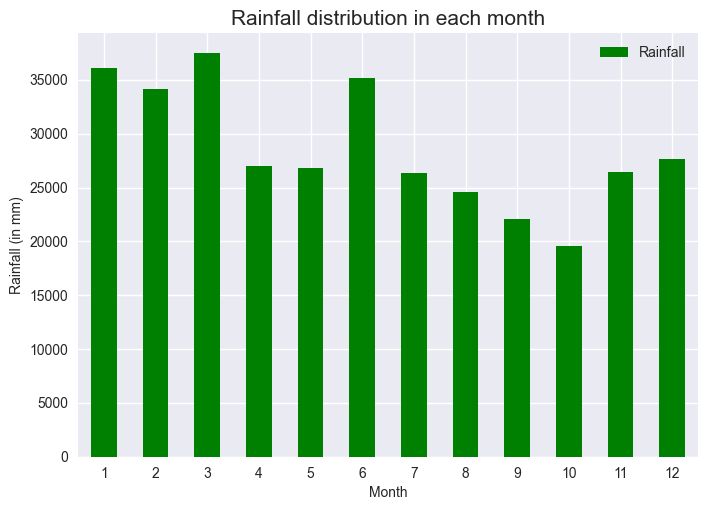

In [10]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
rainfall =[df['Date'].dt.year, df['Date'].dt.month, df['Rainfall']]
headers = ['Year', 'Month', 'Rainfall']
rainfall_df = pd.concat(rainfall, axis=1, keys=headers)

plt.figure(figsize=(10,8))
a = rainfall_df.groupby('Month').agg({'Rainfall':'sum'})
a.plot(kind='bar', color='green')
plt.title('Rainfall distribution in each month', fontsize=15)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Rainfall (in mm)', fontsize=10)
plt.xticks(rotation=0)

### Visualize the rainfall across all different regions of Australia

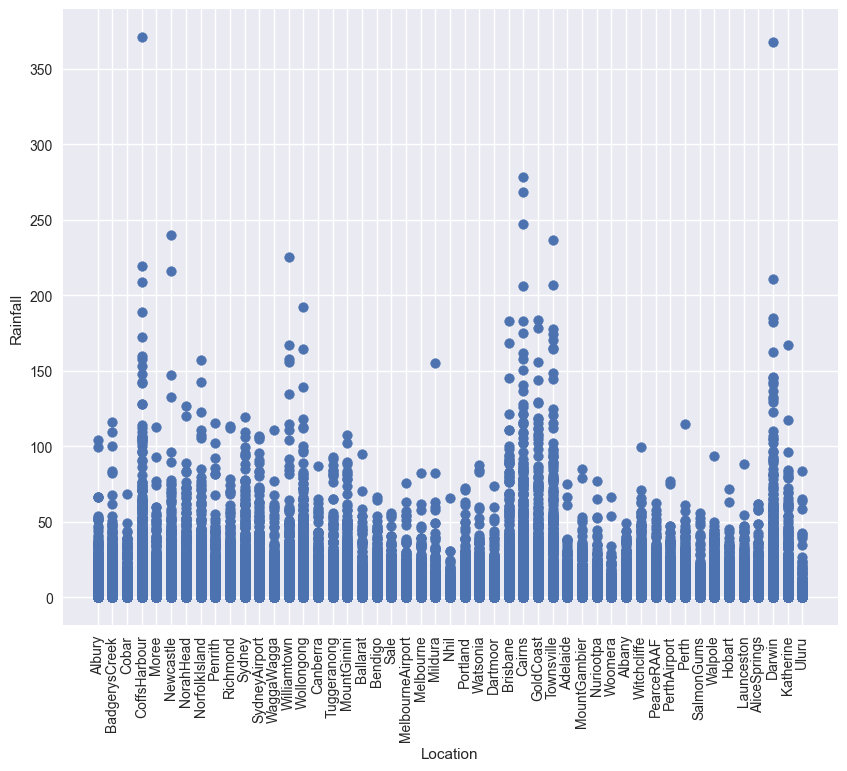

In [11]:
plt.figure(figsize=(10,8))
plt.scatter(df['Location'],df['Rainfall'])
plt.xlabel("Location")
plt.xticks(rotation=90)
plt.ylabel("Rainfall")
plt.show()

In [12]:
df["Date"].dtype

dtype('<M8[ns]')

### Visualize the distributions of the features

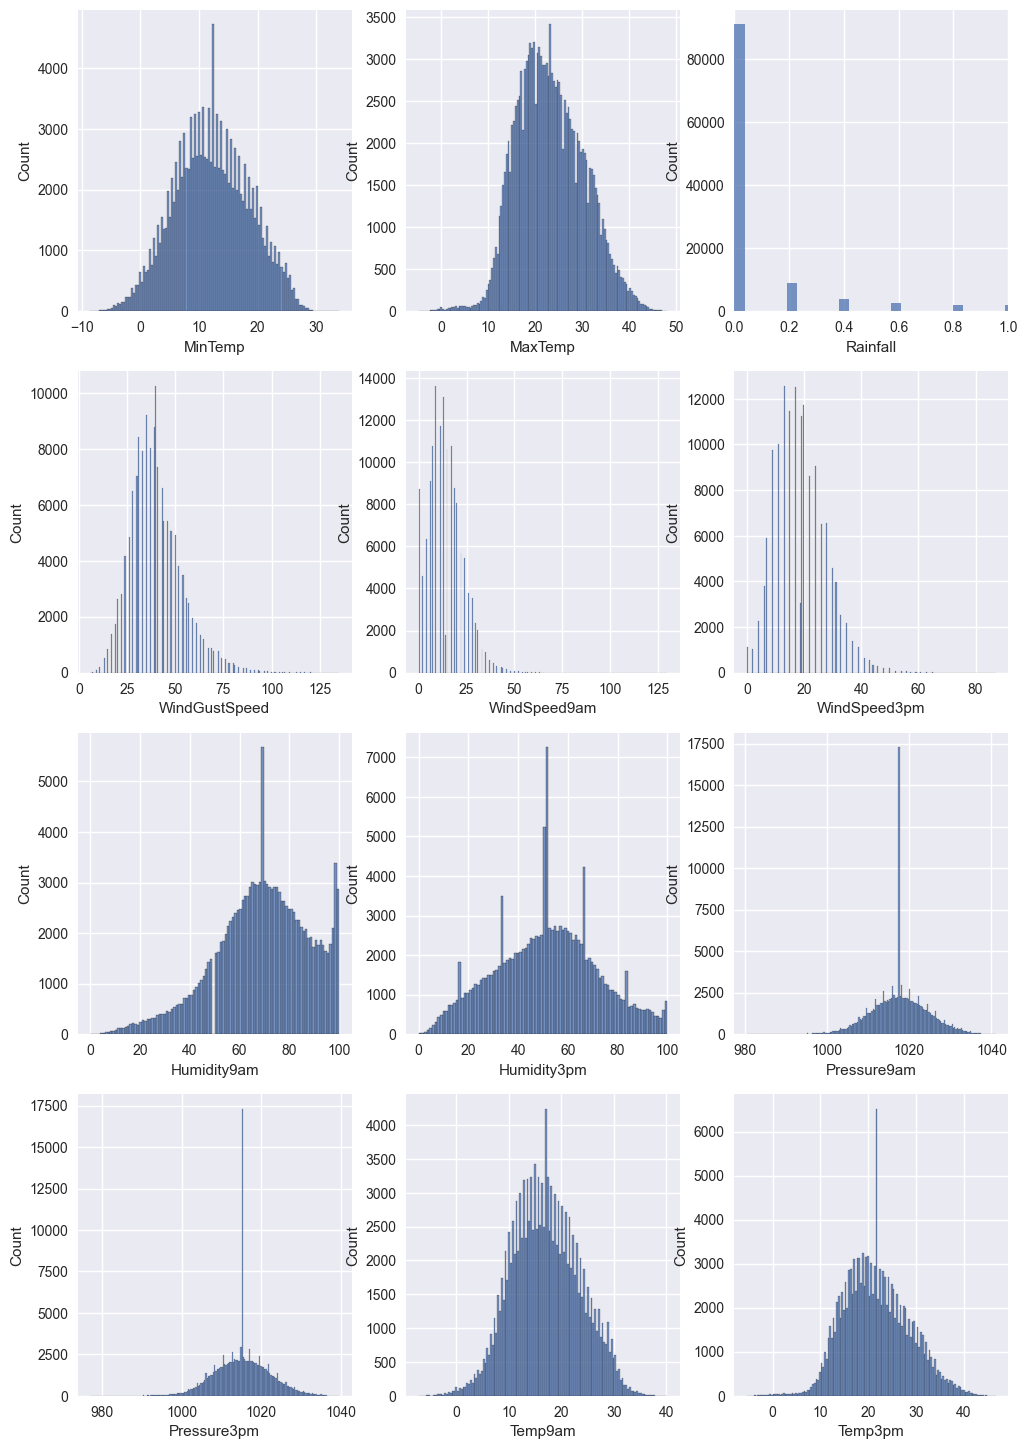

In [13]:
r=4
eps=3
continuous = [col for col in df.columns if (df[col].dtype != object and df[col].dtype !=df["Date"].dtype) ]

fig, axes = plt.subplots(nrows=r,ncols=int(len(continuous)/r), figsize=(12, 18))
axes = axes.reshape(-1)

for i, col in enumerate(continuous):
    sns.histplot(df[col], ax=axes[i])
    left=min(df[col])+eps
    right=max(df[col])+eps
    ##print(left,right)
    if col=="Rainfall":
      axes[i].set_xlim(0, 1)
   

In [14]:
continuous

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [15]:
df.dtypes

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
RainTomorrow             object
dtype: object

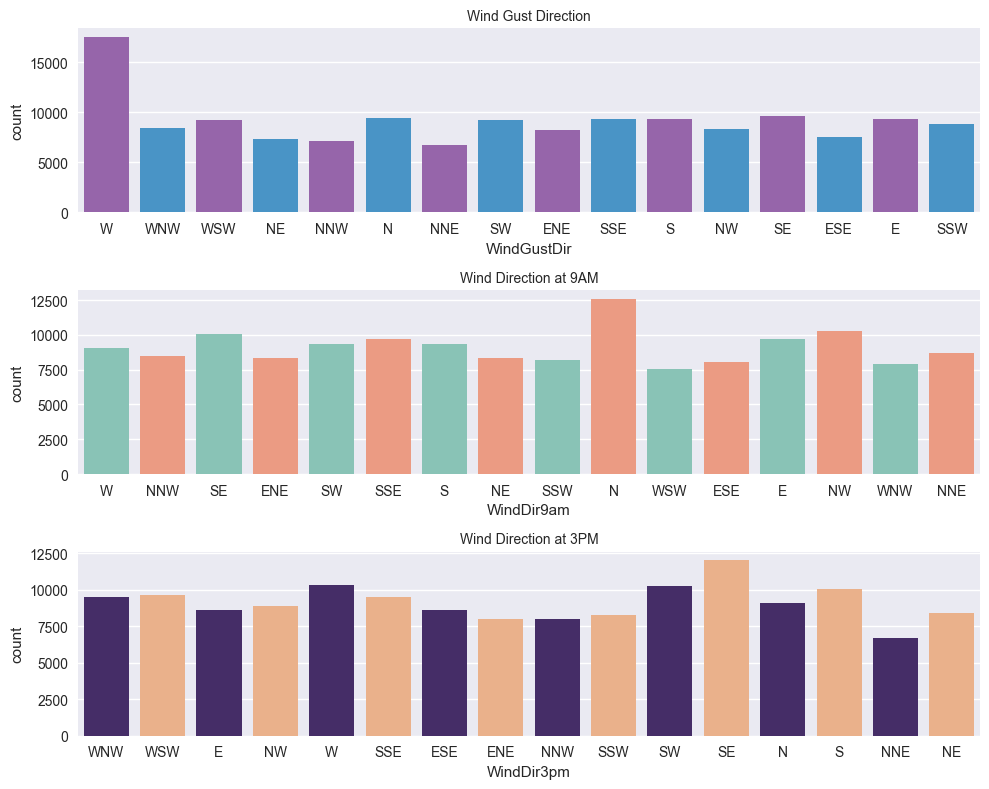

In [16]:
# comparison of WindGustDir, WindDir9am and WindDir3pm

fig, ax = plt.subplots(3, 1, figsize=(10,8))

# WindGustDir
sns.countplot(x=df['WindGustDir'], palette=['#9b59b6','#3498db'], ax=ax[0])
ax[0].set_title("Wind Gust Direction", fontsize=10)

# WindGustDir
sns.countplot(x=df['WindDir9am'], palette= ['#7fcdbb' , '#fc9272'], ax=ax[1])
ax[1].set_title("Wind Direction at 9AM", fontsize=10)

# WindGustDir
sns.countplot(x=df['WindDir3pm'], palette=['#432371',"#FAAE7B"], ax=ax[2])
ax[2].set_title("Wind Direction at 3PM", fontsize=10)
fig.tight_layout()

In [17]:
cat=['WindGustDir','WindDir9am','WindDir3pm']

In [18]:
df.drop(cat,axis=1,inplace=True) 

In [19]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')

### Convert the categorical values to one-hot encoded vectors

In [ ]:
#one_hot_encoded_df = pd.get_dummies(df, columns = ['WindGustDir','WindDir9am','WindDir3pm'])
#print((one_hot_encoded_df).columns)

In [20]:
from sklearn.preprocessing import LabelEncoder
Label_Encoder = LabelEncoder()
df['RainToday']=Label_Encoder.fit_transform(df['RainToday'].astype(str))
df['RainTomorrow']=Label_Encoder.fit_transform(df['RainTomorrow'].astype(str))


In [ ]:
#one_hot_encoded_df.head()

### Get Subset of all the data for Cairns(which has max rainfall)

In [21]:
df_cairns=df[df['Location']=='Cairns']

In [22]:
df_cairns.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
87200,2008-12-01,Cairns,25.2,32.3,0.4,31.0,7.0,13.0,62.0,66.0,1011.3,1008.1,31.2,30.7,0,1
87201,2008-12-02,Cairns,24.2,32.3,8.4,35.0,11.0,13.0,75.0,62.0,1011.9,1008.0,29.0,31.1,1,0
87202,2008-12-03,Cairns,23.9,32.8,0.6,31.0,17.0,20.0,69.0,42.0,1012.2,1009.9,29.1,31.6,0,0
87203,2008-12-04,Cairns,22.2,33.6,0.0,39.0,19.0,24.0,60.0,31.0,1013.3,1010.9,29.6,32.5,0,0
87204,2008-12-05,Cairns,23.2,33.5,0.0,43.0,22.0,26.0,64.0,56.0,1013.8,1011.0,29.7,32.2,0,0


### Split into target variable and input

In [24]:
df_cairns_x = df_cairns.drop(['RainTomorrow','RainToday','Location','Date'],axis=1)

In [26]:
df_cairns_x.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
87200,25.2,32.3,0.4,31.0,7.0,13.0,62.0,66.0,1011.3,1008.1,31.2,30.7
87201,24.2,32.3,8.4,35.0,11.0,13.0,75.0,62.0,1011.9,1008.0,29.0,31.1
87202,23.9,32.8,0.6,31.0,17.0,20.0,69.0,42.0,1012.2,1009.9,29.1,31.6
87203,22.2,33.6,0.0,39.0,19.0,24.0,60.0,31.0,1013.3,1010.9,29.6,32.5
87204,23.2,33.5,0.0,43.0,22.0,26.0,64.0,56.0,1013.8,1011.0,29.7,32.2


In [27]:
df_cairns_norm=df_cairns_x.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [28]:
df_cairns_norm.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
87200,1.252279,1.117982,-0.291474,-0.817659,-1.371768,-1.291421,-0.681138,0.311284,-0.685274,-0.727819,1.906303,1.096922
87201,0.937834,1.117982,0.149803,-0.353298,-0.755404,-1.291421,0.434571,0.018197,-0.541132,-0.752084,1.127179,1.254136
87202,0.843500,1.321907,-0.280443,-0.817659,0.169143,-0.276921,-0.080372,-1.447238,-0.469060,-0.291046,1.162594,1.450655
87203,0.308943,1.648188,-0.313538,0.111064,0.477325,0.302793,-0.852786,-2.253227,-0.204799,-0.048395,1.339668,1.804388
87204,0.623389,1.607403,-0.313538,0.575425,0.939599,0.592650,-0.509491,-0.421433,-0.084680,-0.024129,1.375083,1.686477


Text(0.5, 1.0, 'Temperature at 3PM')

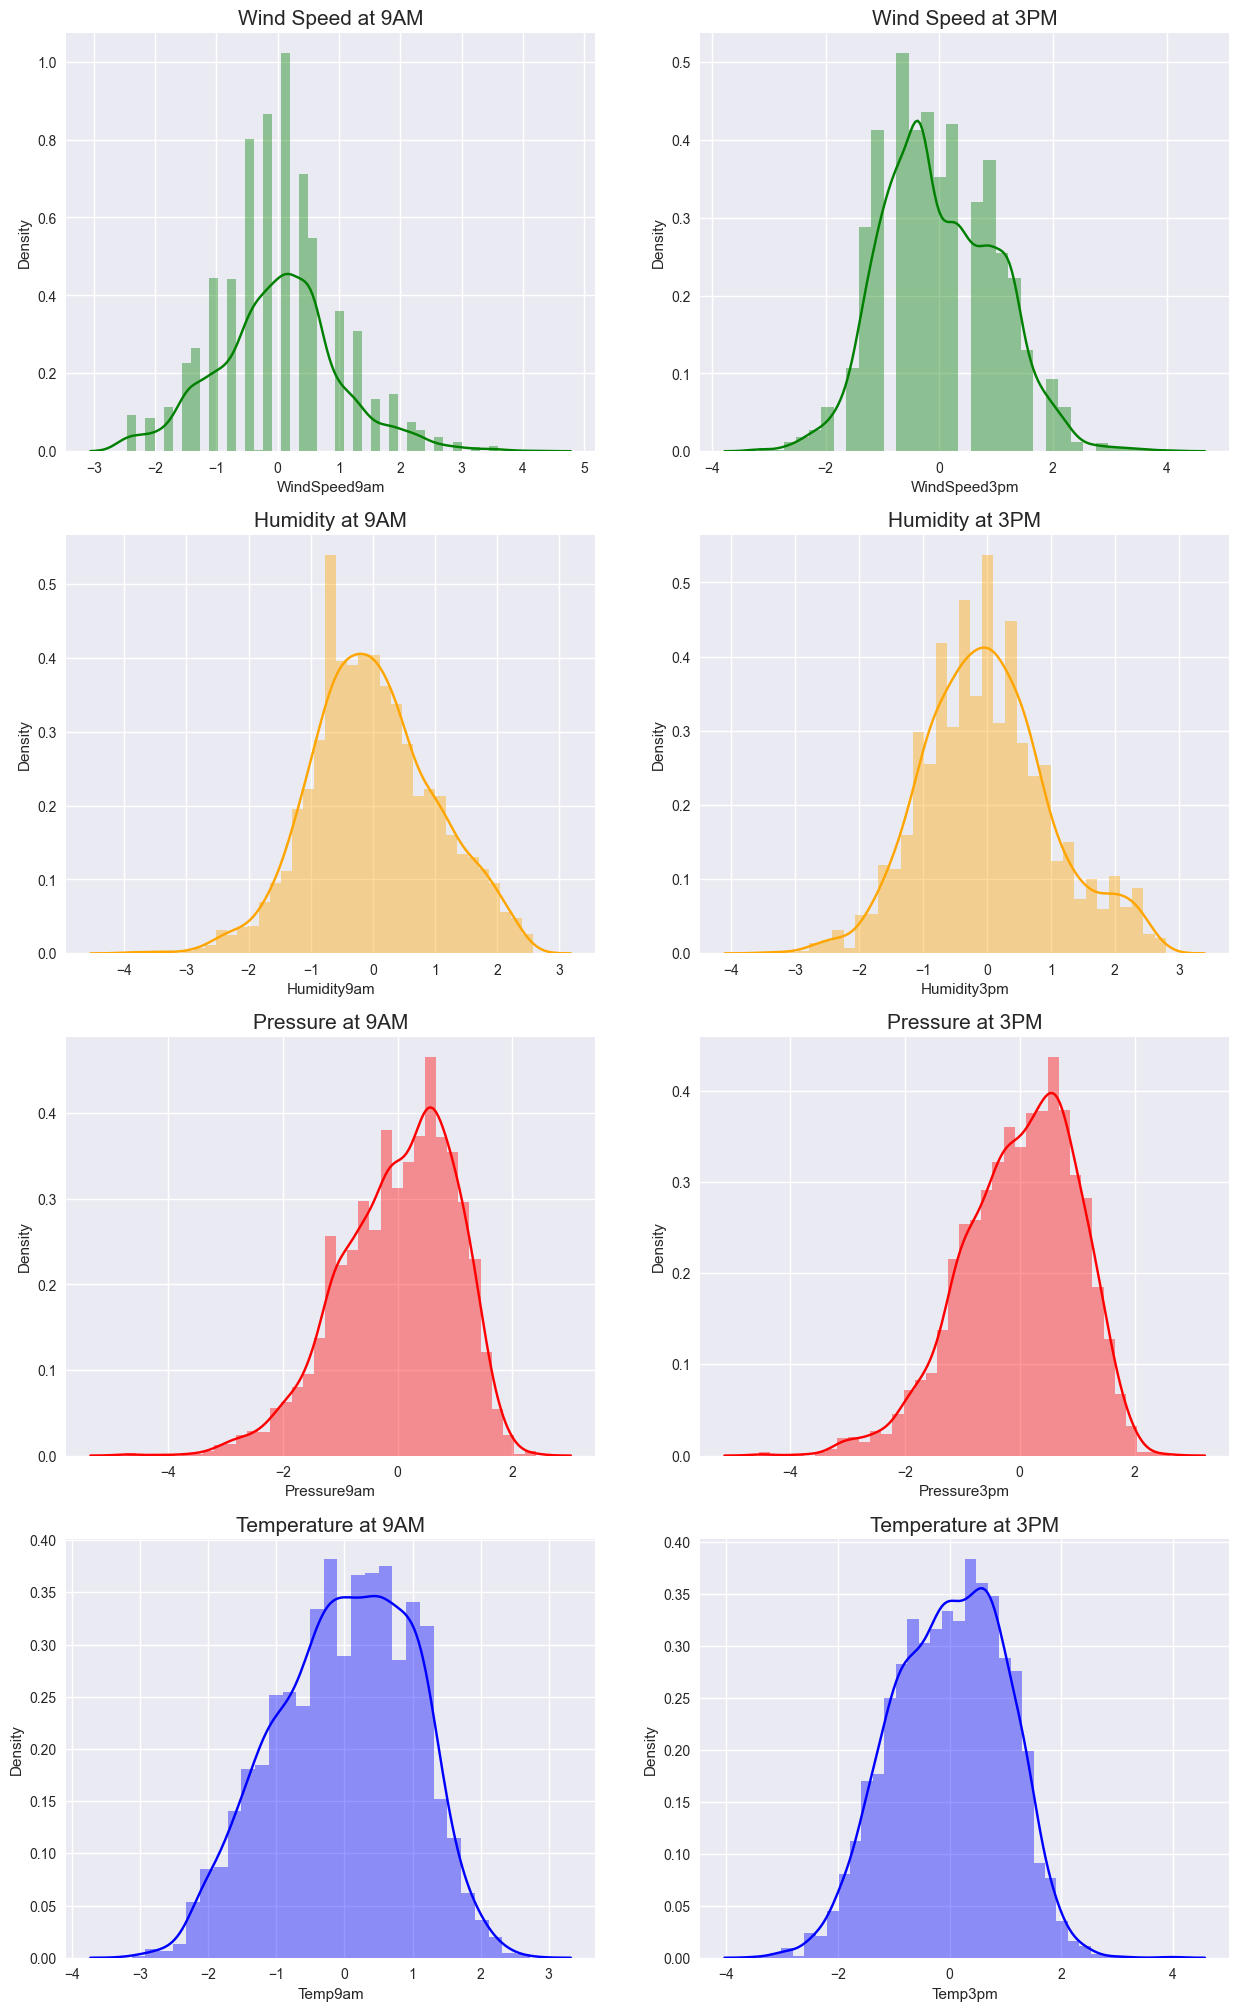

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(15,25))

# WindSpeed9am
sns.distplot(df_cairns_norm['WindSpeed9am'], ax=ax[0,0], color='green')
ax[0,0].set_title("Wind Speed at 9AM", fontsize=15)

# WindSpeed3pm
sns.distplot(df_cairns_norm['WindSpeed3pm'], ax=ax[0,1], color='green')
ax[0,1].set_title("Wind Speed at 3PM", fontsize=15)

# Humidity9am
sns.distplot(df_cairns_norm['Humidity9am'], ax=ax[1,0], color='orange')
ax[1,0].set_title("Humidity at 9AM", fontsize=15)

# Humidity3pm
sns.distplot(df_cairns_norm['Humidity3pm'], ax=ax[1,1], color='orange')
ax[1,1].set_title("Humidity at 3PM", fontsize=15)

# Pressure9am
sns.distplot(df_cairns_norm['Pressure9am'], ax=ax[2,0], color='red')
ax[2,0].set_title("Pressure at 9AM", fontsize=15)

# Pressure3pm
sns.distplot(df_cairns_norm['Pressure3pm'], ax=ax[2,1], color='red')
ax[2,1].set_title("Pressure at 3PM", fontsize=15)

# Temp9am
sns.distplot(df_cairns_norm['Temp9am'], ax=ax[3,0], color='blue')
ax[3,0].set_title("Temperature at 9AM", fontsize=15)

# Temp3pm
sns.distplot(df_cairns_norm['Temp3pm'], ax=ax[3,1], color='blue')
ax[3,1].set_title("Temperature at 3PM", fontsize=15)


In [33]:
x = df_cairns_norm.values
y = df_cairns['RainTomorrow'].values

In [34]:
print(type(x),type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [35]:
print(x[0])
print(y[0:5])

[ 1.25227938  1.11798189 -0.2914745  -0.81765914 -1.37176806 -1.29142056
 -0.68113812  0.31128446 -0.68527443 -0.72781909  1.90630338  1.09692164]
[1 0 0 0 0]


In [36]:
x.shape

(3040, 12)

### Split into training and test set

In [37]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.01,random_state=100) 

### Normalize the features 

In [ ]:
## Find the mean of each column 

mean_train = np.mean(x_train,axis=0)
sd_train = np.std(x_train,axis=0)

mean_train=mean_train.reshape((-1,len(mean_train)))
sd_train=sd_train.reshape((-1,len(sd_train)))

#print(mean_train.shape)
#print(sd_train.shape)
#print(x_train.shape)

## Normalize the data 
x_train_norm = (x_train - mean_train)/(sd_train)
x_test_norm = (x_test - mean_train)/(sd_train)

#print(x_train[0:2])
#print(x_train_norm[:,1])


In [ ]:
## Replace nans by mean which is 0 (Assuming standard normal)

x_train_norm[np.isnan(x_train_norm)] = 0
x_test_norm[np.isnan(x_test_norm)] = 0

In [39]:
x_train[0]

array([ 0.2146096 , -0.02400151,  0.07257904,  0.57542488, -0.75540354,
        0.30279264,  1.2928086 ,  0.01819743, -0.42101283, -0.3638417 ,
       -0.32482414,  0.31084812])

In [40]:
assert np.count_nonzero(np.isfinite(x_train))==(x_train.shape[0])*(x_train.shape[1])
assert np.count_nonzero(np.isfinite(x_test))==(x_test.shape[0])*(x_test.shape[1])

#### Use dynamax to feed training set into Hidden Markov Model (Gaussian emissions with Autoregressive contributions )

In [143]:
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation


In [144]:
jr.PRNGKey(1)

Array([0, 1], dtype=uint32)

In [145]:
x_train.shape

(3009, 12)

In [146]:
x_test.shape

(31, 12)

In [212]:
## Define the parameters of the HMM 

num_states = 4
emission_dim = 12 
num_lags = 1

sgd_hmm = LinearAutoregressiveHMM(num_states=num_states, emission_dim=emission_dim, num_lags=num_lags,transition_matrix_stickiness=10.0)

train_emissions =np.copy(np.around(x_train,decimals=2))


In [213]:
print(train_emissions.shape)

(3009, 12)


In [214]:
train_inputs = sgd_hmm.compute_inputs(train_emissions)

print(train_emissions.shape)
print(train_inputs.shape)

(3009, 12)
(3009, 12)


In [215]:
train_emissions

array([[ 0.21, -0.02,  0.07, ..., -0.36, -0.32,  0.31],
       [ 1.19,  0.51, -0.14, ..., -0.61,  0.53,  0.98],
       [ 0.87,  1.81, -0.3 , ..., -1.53,  1.87,  0.23],
       ...,
       [ 0.65,  0.18,  0.84, ..., -0.41, -0.18,  0.66],
       [ 0.87,  1.  , -0.31, ..., -0.63,  1.23,  0.59],
       [ 0.03, -0.51, -0.29, ..., -0.07, -0.15, -0.32]])

In [216]:
train_inputs

Array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.21, -0.02,  0.07, ..., -0.36, -0.32,  0.31],
       [ 1.19,  0.51, -0.14, ..., -0.61,  0.53,  0.98],
       ...,
       [ 0.43,  1.32, -0.31, ..., -2.21,  1.02,  1.65],
       [ 0.65,  0.18,  0.84, ..., -0.41, -0.18,  0.66],
       [ 0.87,  1.  , -0.31, ..., -0.63,  1.23,  0.59]], dtype=float32)

In [217]:
#print(np.count_nonzero(np.isnan(emissions)))
#print(np.count_nonzero(np.isnan(inputs)))

#print(np.count_nonzero(np.isfinite(emissions)))
#print(np.count_nonzero(np.isfinite(inputs)))

#print(emissions.dtype)


In [218]:
transition_matrix = jnp.ones((num_states, num_states))/(num_states)

In [219]:
transition_matrix.shape

(4, 4)

In [220]:
initial_probs = jnp.ones((num_states, ))/(num_states)

In [221]:
initial_probs.shape

(4,)

In [222]:
params_sgd, props_sgd = sgd_hmm.initialize(key=jr.PRNGKey(1), method="prior", emissions=train_emissions, transition_matrix=transition_matrix, initial_probs=initial_probs)

In [223]:
params_sgd

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.25, 0.25, 0.25, 0.25], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]], dtype=float32)), emissions=ParamsLinearRegressionHMMEmissions(weights=Array([[[ 9.50916767e-01, -1.50978668e-02, -6.77874265e-03,
         -9.86848306e-03,  1.62468338e-03,  6.78198924e-03,
          9.51857306e-03, -1.22490209e-02,  1.28240732e-03,
         -2.72076088e-03, -3.82073713e-03,  1.65548716e-02],
        [-4.50015487e-03,  9.67951894e-01,  4.46557719e-03,
          1.66284852e-02, -8.72333441e-03, -3.07689980e-03,
          3.39191733e-03,  8.19467194e-03, -1.17623424e-02,
          1.18877189e-02,  1.34703908e-02,  9.75235458e-03],
        [-4.93629975e-03,  3.36721214e-03,  9.22334790e-01,
          1.38898485e-03,  1.64248666e-03, -3.15029249e-02,
         -1.5

In [224]:
props_sgd

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=<dynamax.parameters.ParameterProperties object at 0x2b9978590>), transitions=ParamsStandardHMMTransitions(transition_matrix=<dynamax.parameters.ParameterProperties object at 0x2c02b92d0>), emissions=ParamsLinearRegressionHMMEmissions(weights=<dynamax.parameters.ParameterProperties object at 0x2c044ae50>, biases=<dynamax.parameters.ParameterProperties object at 0x2c04480d0>, covs=<dynamax.parameters.ParameterProperties object at 0x2b98e8c10>))

In [225]:
fitted_params_sgd, lps_sgd = sgd_hmm.fit_sgd(params_sgd, props_sgd, train_emissions,inputs=train_inputs,num_epochs=2000)

In [226]:
fitted_params_sgd

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.09863051, 0.6942249 , 0.06468555, 0.14245899], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.1518331 , 0.6323773 , 0.05314661, 0.16264291],
       [0.05206383, 0.7767172 , 0.03905119, 0.13216771],
       [0.05023903, 0.73590624, 0.08032232, 0.13353233],
       [0.08667921, 0.6754424 , 0.07079718, 0.16708125]], dtype=float32)), emissions=ParamsLinearRegressionHMMEmissions(weights=Array([[[ 1.99761316e-01,  6.79777563e-02,  3.50814238e-02,
         -8.21242183e-02,  1.14505142e-02,  5.17102294e-02,
         -7.38132447e-02, -6.20364025e-02, -5.93458638e-02,
          1.17180217e-02, -9.49244946e-02, -9.86371338e-02],
        [ 1.19857177e-01,  2.98554450e-01,  2.44474784e-02,
          5.41573279e-02,  4.92144786e-02, -2.21315622e-02,
         -9.81900003e-03, -3.21291536e-02, -5.36618801e-03,
          6.20191125e-03, -2.22650189e-02, -1.87846661e-01],
        [ 1.5

In [227]:
lps_sgd

Array([2.0656826, 2.0554018, 2.0453165, ..., 0.6704059, 0.6703257,
       0.6702455], dtype=float32)

### Log Probability of the Observed Emissions

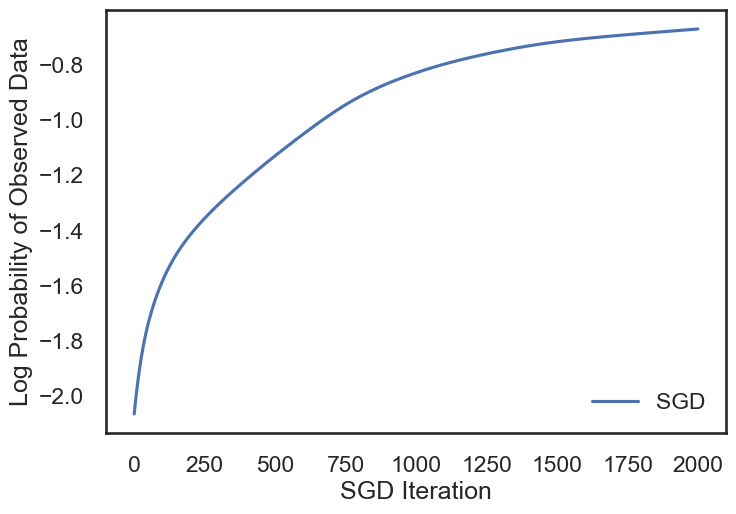

In [228]:
sns.set_style("white")
sns.set_context("talk")
plt.plot(-lps_sgd, label="SGD")
plt.xlabel("SGD Iteration")
plt.ylabel("Log Probability of Observed Data")
plt.legend(loc="lower right")
plt.show()

In [229]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "orange",
     "red",
    "brown",
    "pink",
    "amber",
    "faded green",
    "dusty purple"
    
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [230]:
### Plot the emissions using TSNE Plots

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(train_emissions)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3009 samples in 0.003s...
[t-SNE] Computed neighbors for 3009 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3009
[t-SNE] Computed conditional probabilities for sample 2000 / 3009
[t-SNE] Computed conditional probabilities for sample 3000 / 3009
[t-SNE] Computed conditional probabilities for sample 3009 / 3009
[t-SNE] Mean sigma: 0.688189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.445580
[t-SNE] KL divergence after 1000 iterations: 1.509392


In [231]:
most_likely_states = sgd_hmm.most_likely_states(fitted_params_sgd, train_emissions, inputs=train_inputs)

In [232]:
most_likely_states

Array([1, 1, 2, ..., 3, 1, 1], dtype=int32)

Text(0.5, 1.0, 'TSNE Plot of the emissions (coloured by hidden state)')

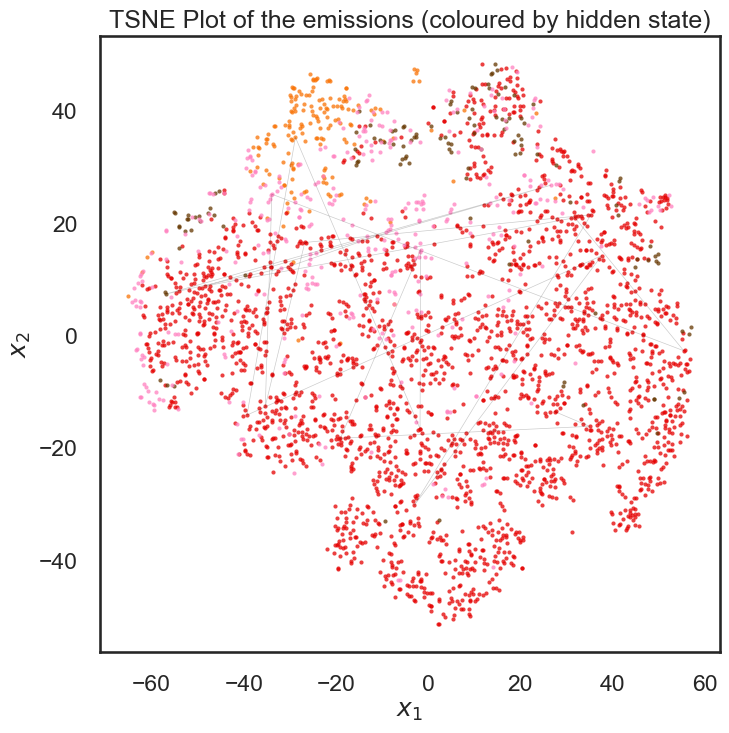

In [233]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*z[most_likely_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*z[:20].T, '-k', lw=0.5, alpha=0.2)    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")    
plt.title("TSNE Plot of the emissions (coloured by hidden state)")

### Look at some of the predictions for amount of rainfall

In [ ]:
posterior = sgd_hmm.smoother(fitted_params_sgd, emissions, inputs=inputs)
most_likely_states = sgd_hmm.most_likely_states(fitted_params_sgd, emissions, inputs=inputs)

In [ ]:
most_likely_states

In [ ]:
## Plot the amount of rainfall and 

In [ ]:
posterior

In [ ]:
emissions_test =np.copy(x_test)
inputs_test = sgd_hmm.compute_inputs(emissions_test)
print(sgd_hmm.marginal_log_prob(fitted_params_sgd, emissions_test, inputs=inputs_test))